In [ ]:
#from threads_to_doc_list import threads_to_doc_list

In [ ]:
filename = '/kaggle/input/reddit-worldcup/reddit_worldcup_data_500_weekly2022-11-21 11_56_41.json'

#doc_list = threads_to_doc_list(filename)#, 1668988801)
doc_list = threads_to_exploded_doc_list(filename, 1668988801)

In [ ]:
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
import pandas as pd
import gensim
import pyLDAvis.gensim
import nltk

nltk.download('omw-1.4', quiet=True)

In [ ]:
drop_word_list = ['www', 'http', 'com', 'country', 'world', 'cup']
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop_and_drop_list = get_stop_words('en') + drop_word_list
lemmatizer = WordNetLemmatizer()


In [ ]:
def preprocess_doc(doc):
    doc = doc.lower()
    tokenized_doc = tokenizer.tokenize(doc)
    no_stop_word_tokens = [token for token in tokenized_doc if not token in en_stop_and_drop_list]
    lemma_tokens = [lemmatizer.lemmatize(token) for token in no_stop_word_tokens]
    processed_doc = [token for token in lemma_tokens if not len(token) == 1]
    return processed_doc

def preprossess_doc_list(doc_list):
    clean_doc_list = []
    for d in doc_list:
        clean_doc_list.append(preprocess_doc(d))
    return clean_doc_list
        

In [ ]:
processed_doc_list = preprossess_doc_list(doc_list)

In [ ]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(word_list_lemmatized)#processed_doc_list)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in word_list_lemmatized]#processed_doc_list]

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
import pprint
pprint.pprint(ldamodel.top_topics(corpus,topn=5))

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

In [ ]:
print(ldamodel.get_document_topics(corpus))

In [ ]:
top_topics = []
for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    top_topics.append(row)

In [ ]:
len(top_topics)

In [ ]:
top_topics[5]

In [ ]:
doc_list[10]

In [ ]:
len(doc_list)

In [ ]:
word_list_lemmatized = run_preprocess(doc_list, extra_stops=drop_word_list)

In [ ]:
len(word_list_lemmatized)

In [ ]:
drop_word_list

In [ ]:
import urlparse

In [ ]:
word_list_lemmatized[1]

In [ ]:
len(doc_list)

In [ ]:
t = drop_urls(doc_list)

In [ ]:
len(t)

In [ ]:
t[0]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Start Here

In [32]:
!pip install -q top2vec[sentence_encoders]

import json
from top2vec import Top2Vec
import re
import pandas as pd

def load_data(filename):
    with open(filename,"r") as f:
        d = json.load(f)
    return d

def parse_submissions(data):
    doc_list = []
    for submission in data:
        submission_texts = submission.get('title', '') + ' ' + submission.get('selftext', '') + ' '
        for reply in submission.get('top_level_replies', []):
            submission_texts = submission_texts + reply.get('body', '') + ' '
        doc_list.append(submission_texts)
    return doc_list

def num_words(text):
    return len(text.split(' '))

def parse_submissions_exploded(data, latest_time=None):
    doc_list = []
    for submission in data:
        if latest_time is None or submission.get('created_utc', 0) <= latest_time:
            if num_words(submission.get('title', '')) >= 5:
                doc = {'text':submission.get('title', ''), 'created_utc':submission.get('created_utc', 0)}
                doc_list.append(doc)
            reply_list = submission.get('top_level_replies', []) + submission.get('replies', [])
            for reply in reply_list:
                if num_words(reply.get('body', '')) >= 5:
                    doc = {'text':reply.get('body', ''), 'created_utc':submission.get('created_utc', 0)}
                    doc_list.append(doc)
    return doc_list

def threads_to_doc_list(filename):
    data = load_data(filename)
    return parse_submissions(data)

def threads_to_exploded_doc_list(filename, latest_time=None):
    data = load_data(filename)
    return parse_submissions_exploded(data, latest_time)

In [33]:
pre_group_stage_filename = '/kaggle/input/reddit-worldcup/reddit_worldcup_data_500_weekly2022-11-21 11_56_41.json'
group_stage_filename = '/kaggle/input/reddit-worldcup/reddit_worldcup_500_2022-12-02 22_39_18.json'

group_stage_start_utc = 1668988801

#doc_list = threads_to_doc_list(filename)#, 1668988801)
doc_dict_list = threads_to_exploded_doc_list(pre_group_stage_filename, group_stage_start_utc) + \
           threads_to_exploded_doc_list(group_stage_filename)

doc_list = [re.sub(r'http\S+', '', doc['text']) for doc in doc_dict_list]
doc_list = [re.sub(r'www\S+', '', doc['text']) for doc in doc_dict_list]

In [ ]:
#!pip install -q top2vec
#!pip install -q sentence_transformers

In [ ]:
#!pip install -q top2vec[sentence_encoders]

In [35]:
len(doc_list)
doc_dict_list[50500:50505]

[{'text': 'Those Saudi guys really like being with other guys.',
  'created_utc': 0},
 {'text': 'lol women have the right to parade themselves around if they want. they dont need someone else to do it for them',
  'created_utc': 0},
 {'text': 'Your Western view of the world isn’t absolute and universal',
  'created_utc': 0},
 {'text': 'El Paso doing just fine. That city on the other side of the wall though….I feel for Mexican women having to live life in fear like that',
  'created_utc': 0},
 {'text': 'Lets just settle this right now - both cultures are broken lol',
  'created_utc': 0}]

In [30]:
len(doc_list)

79280

In [36]:
top2vec_use = Top2Vec(documents=doc_list, speed="learn", embedding_model='universal-sentence-encoder')
#top2vec_bert = Top2Vec(documents=doc_list, speed="learn", embedding_model='all-MiniLM-L6-v2')

2022-12-04 00:53:35,751 - top2vec - INFO - Pre-processing documents for training
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-12-04 00:53:43,205 - top2vec - INFO - Downloading universal-sentence-encoder model
2022-12-04 00:54:15.838697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-04 00:54:15.838771: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 00:54:15.838802: I tensorfl

ImportError: all-MiniLM-L6-v2 is not available.

Try: pip install top2vec[sentence_transformers]

Alternatively try: pip install torch sentence_transformers

In [37]:
top2vec_use.get_num_topics()

325

In [ ]:
#topic_words, word_scores, topic_nums = top2vec.get_topics()

In [ ]:
#for topic in topic_nums[0:19]:
#    top2vec.generate_topic_wordcloud(topic, background_color="black")

In [ ]:
#topic_mapping = model.hierarchical_topic_reduction(num_topics=20)


In [ ]:
#len(doc_list)

In [38]:
def print_top_topic_docs(model, reduced=False):
    for topic_num in range(model.get_num_topics(reduced=reduced)):
        documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=5, reduced=reduced)
        print(topic_num)
        for doc, score, doc_id in zip(documents, document_scores, document_ids):
            print(f"Document: {doc_id}, Score: {score}")
            print("-----------")
            print(doc)
            print("-----------")
            print()

In [40]:
#print_top_topic_docs(top2vec_use)

In [ ]:
topic_mapping = top2vec.hierarchical_topic_reduction(num_topics=15)

In [ ]:
print_top_topic_docs(top2vec, reduced=True)

In [42]:
topic_mapping = top2vec_use.hierarchical_topic_reduction(num_topics=15)
print_top_topic_docs(top2vec_use, True)

0
Document: 64112, Score: 0.710105299949646
-----------
Lmao your fucking joking right?
-----------

Document: 65091, Score: 0.7053671479225159
-----------
Damn you stupid as hell lmao
-----------

Document: 11097, Score: 0.6865602731704712
-----------
Haha, that's not an explanation, you imbecile.
-----------

Document: 28163, Score: 0.6846230030059814
-----------
Dude you just dont get it….
-----------

Document: 76584, Score: 0.6772261261940002
-----------
Omg you were right! So fkn dumb
-----------

1
Document: 60692, Score: 0.7524232864379883
-----------
Messi’s dive at 80 minutes was just so obvious. If he had scored an equaliser from that, it would have ruined the whole game.
-----------

Document: 72295, Score: 0.7480214834213257
-----------
My take is that 0-0 would be a final score more in line with how the match went by. Senegal was pretty bad at shooting on goal, but it kept Holland in check until they got desperate at end. Mendy didn’t have much help from his defenders on 

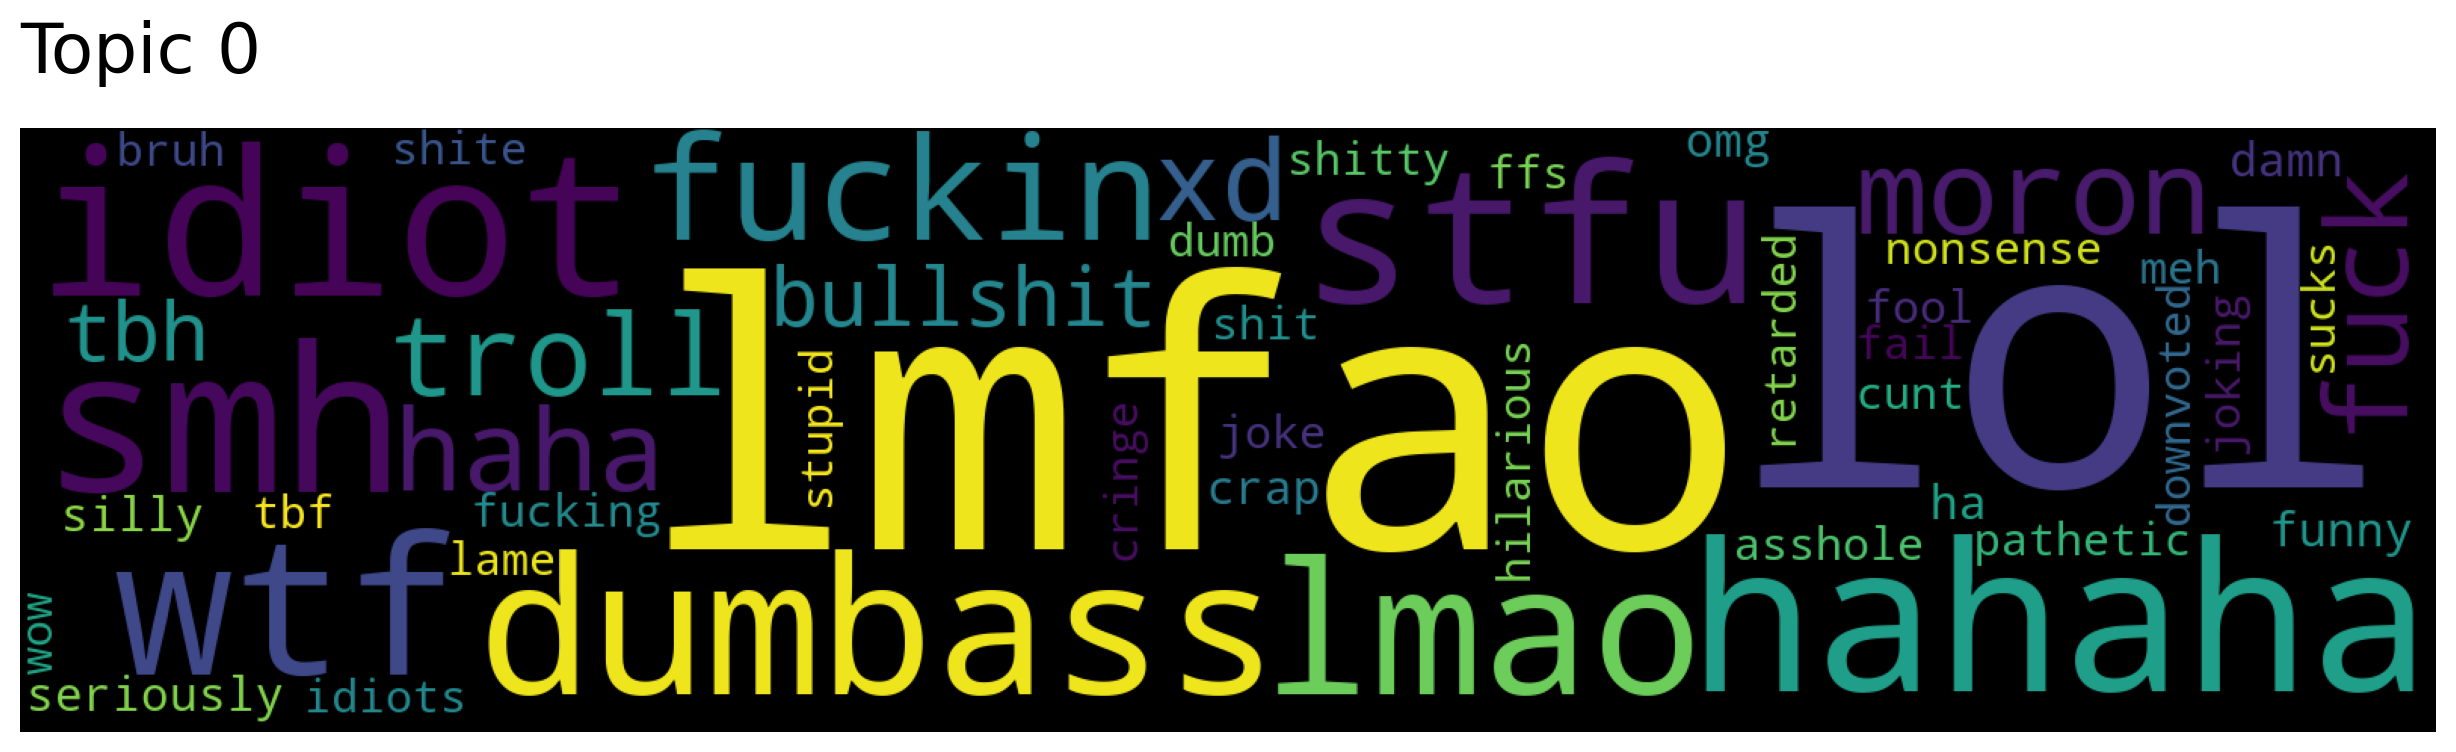

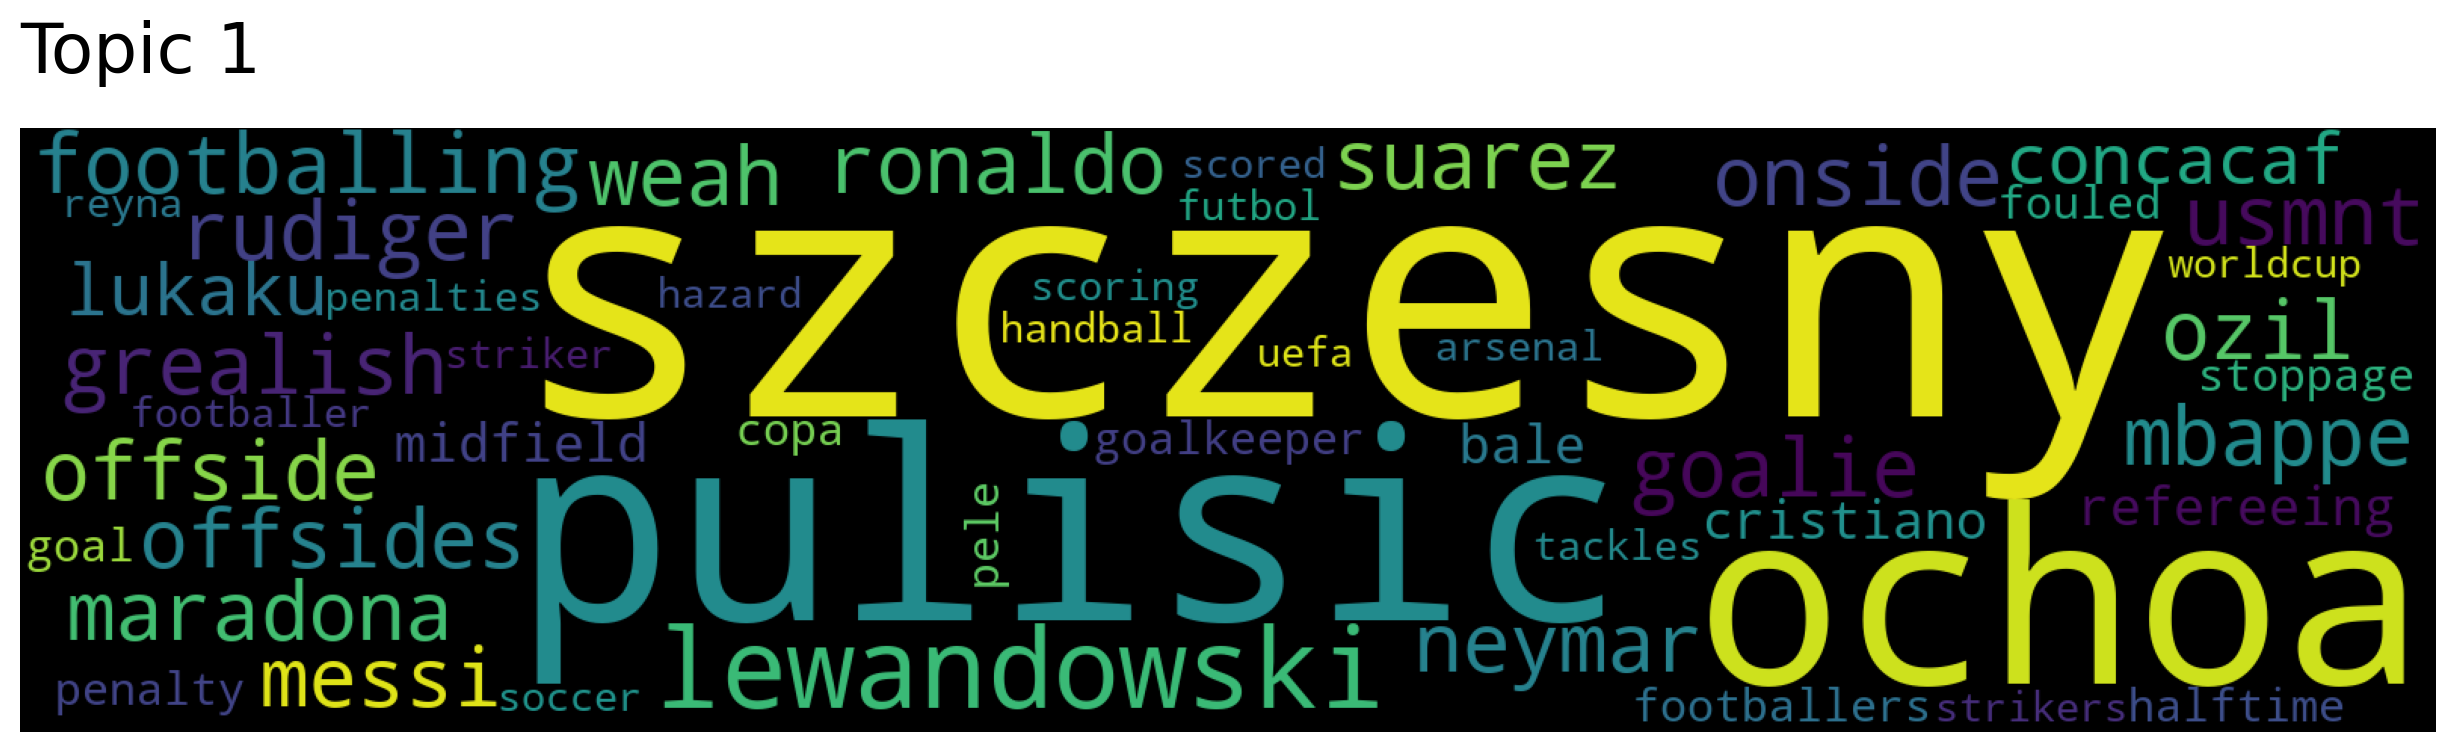

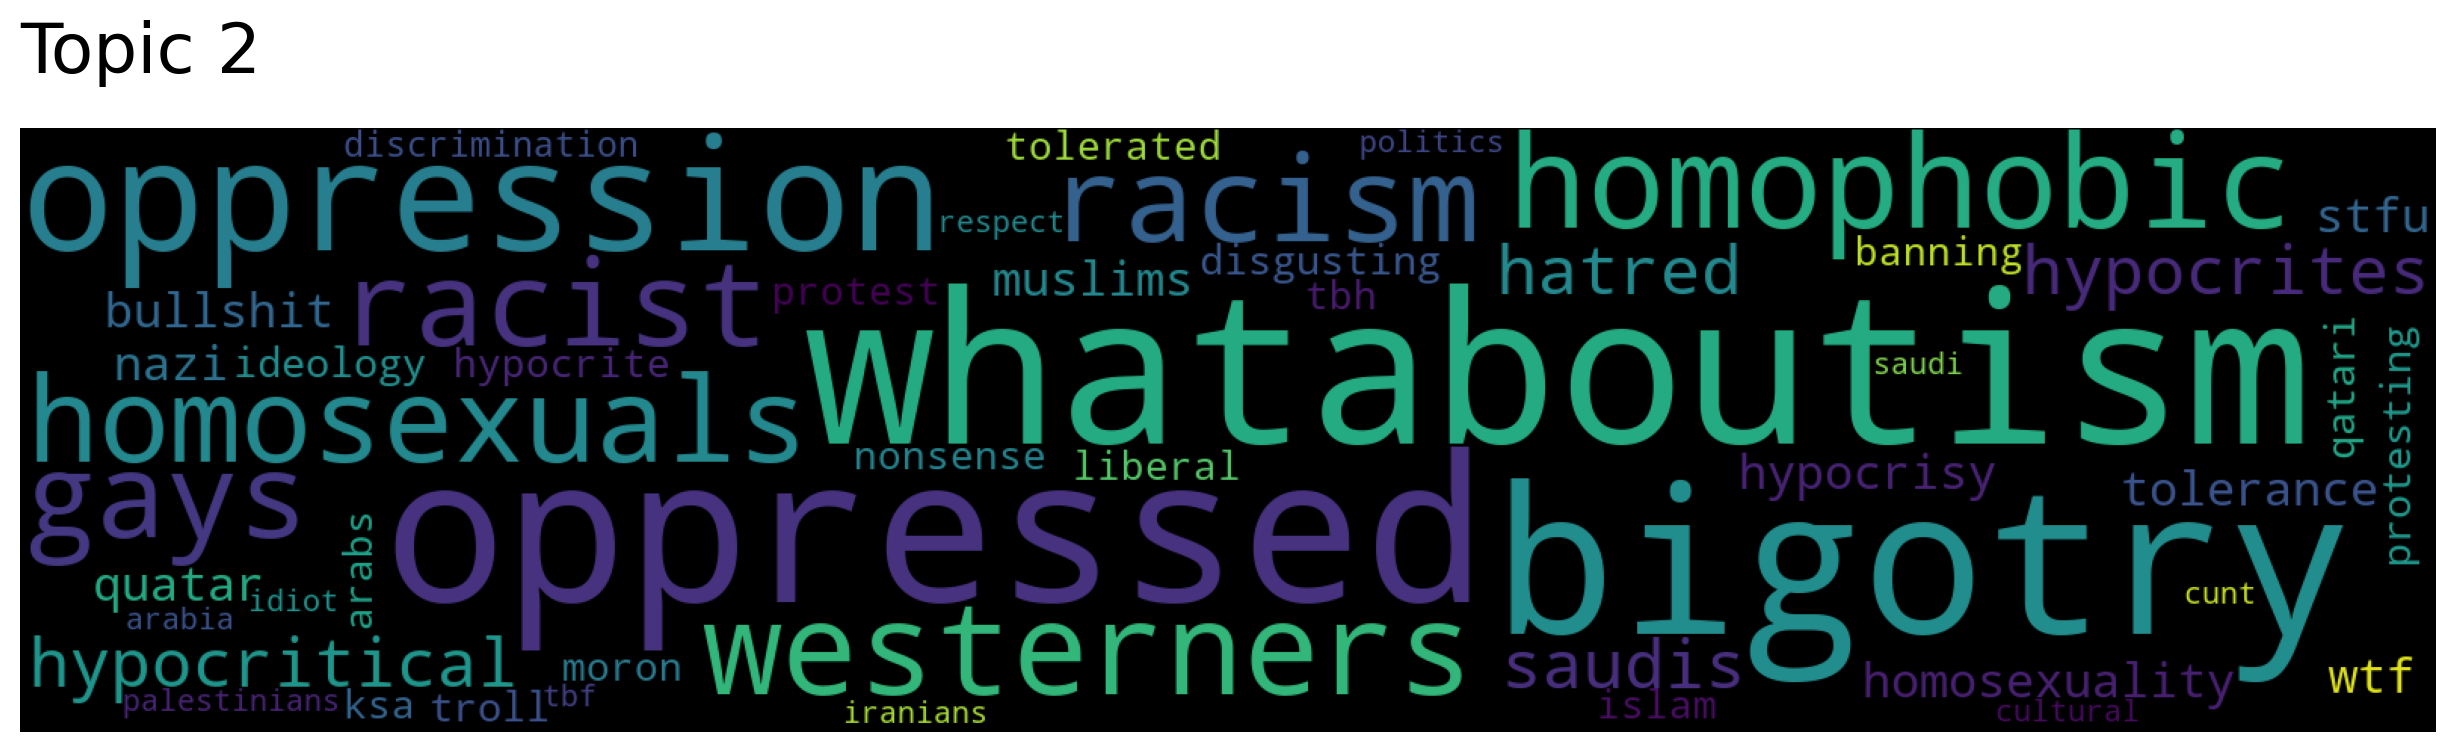

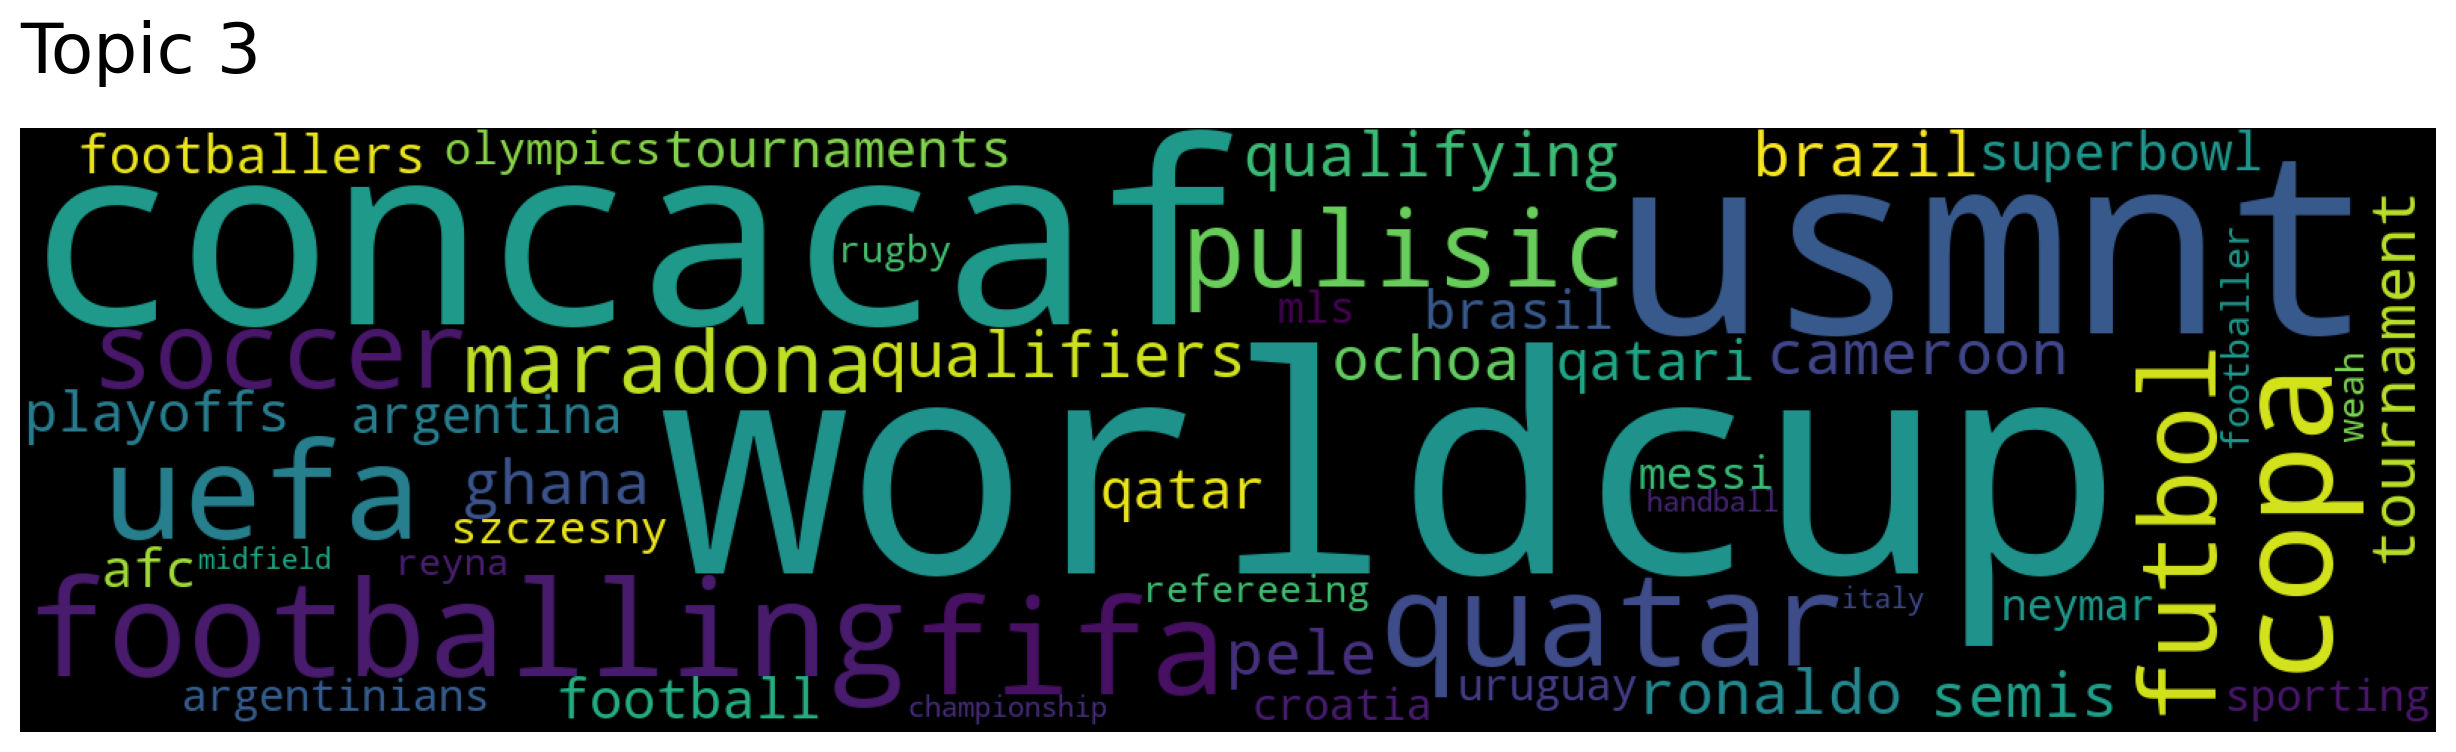

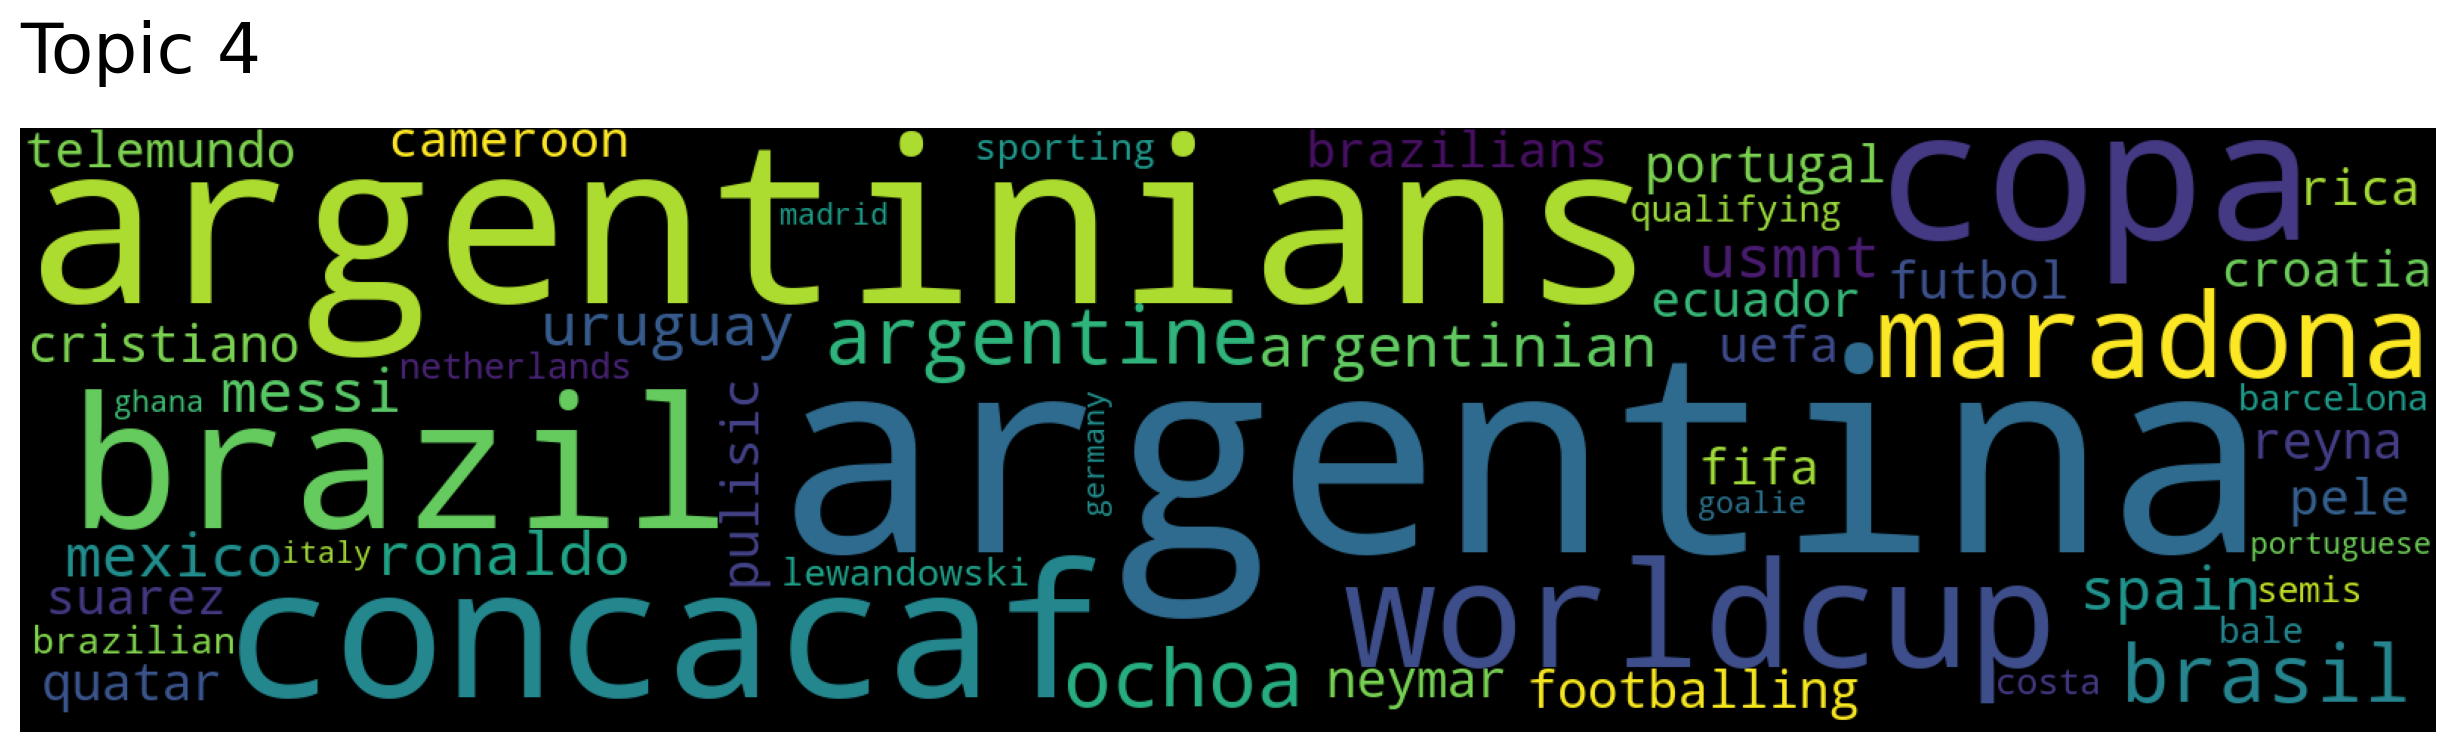

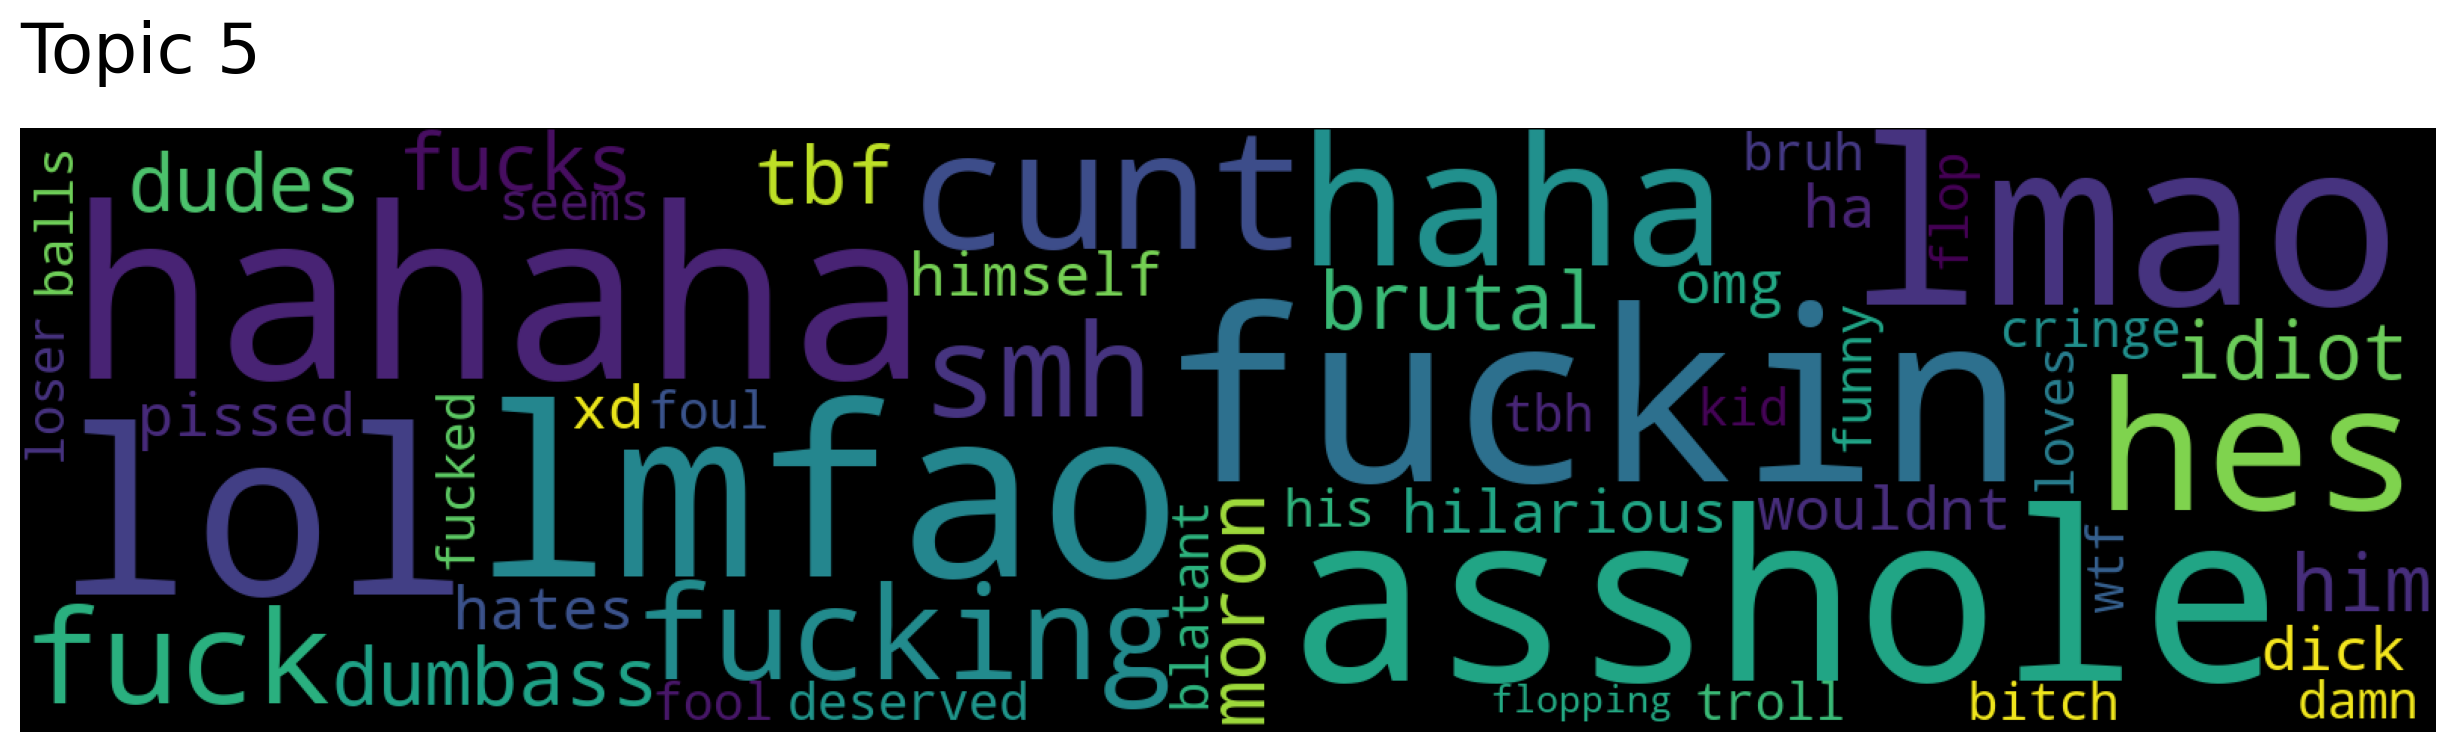

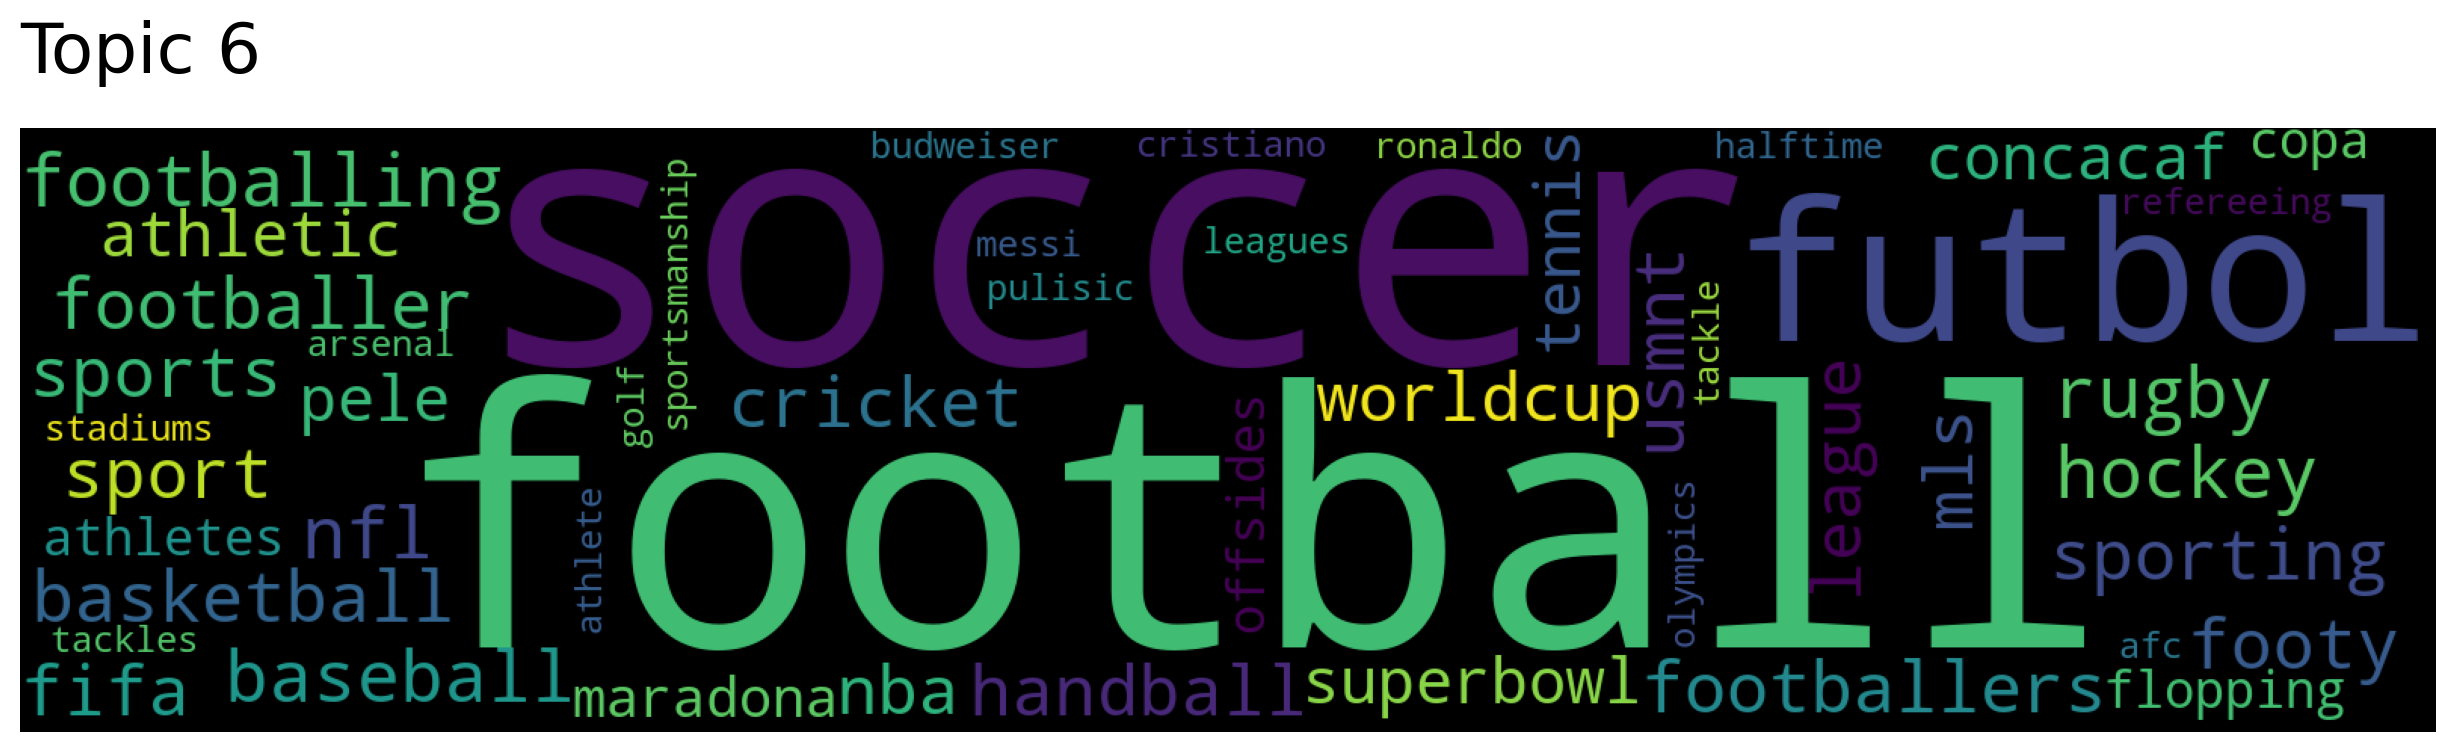

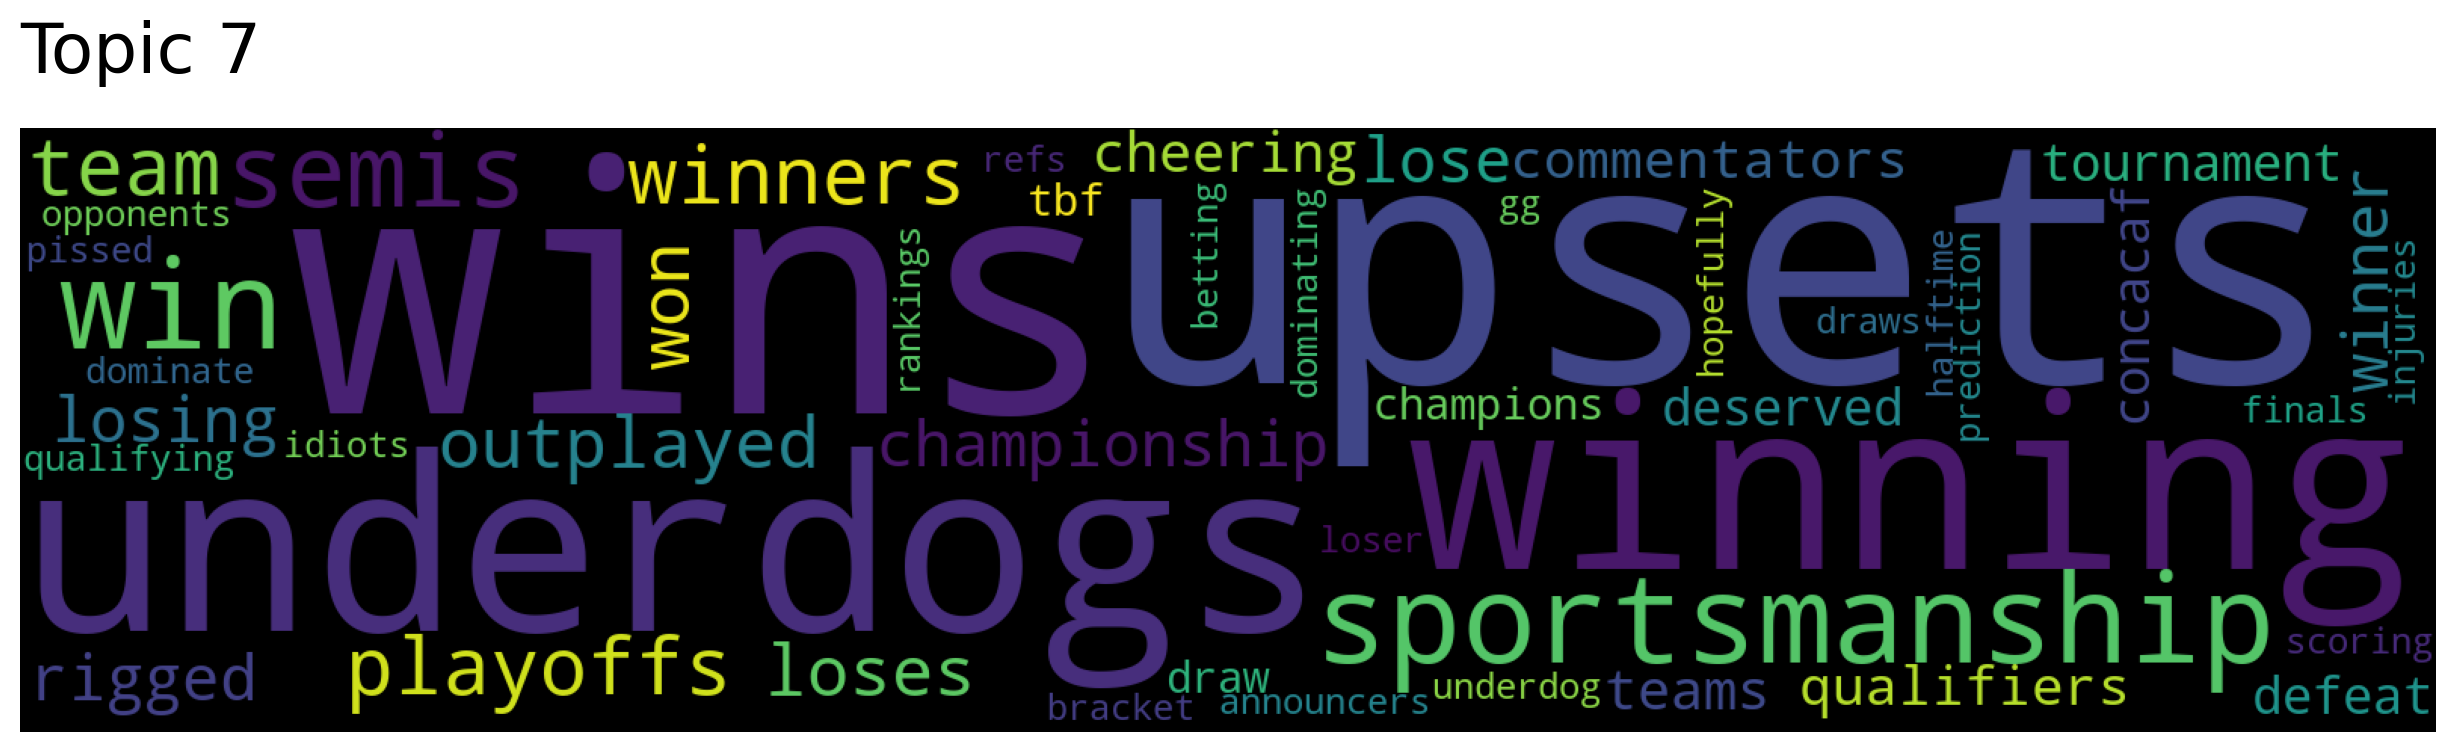

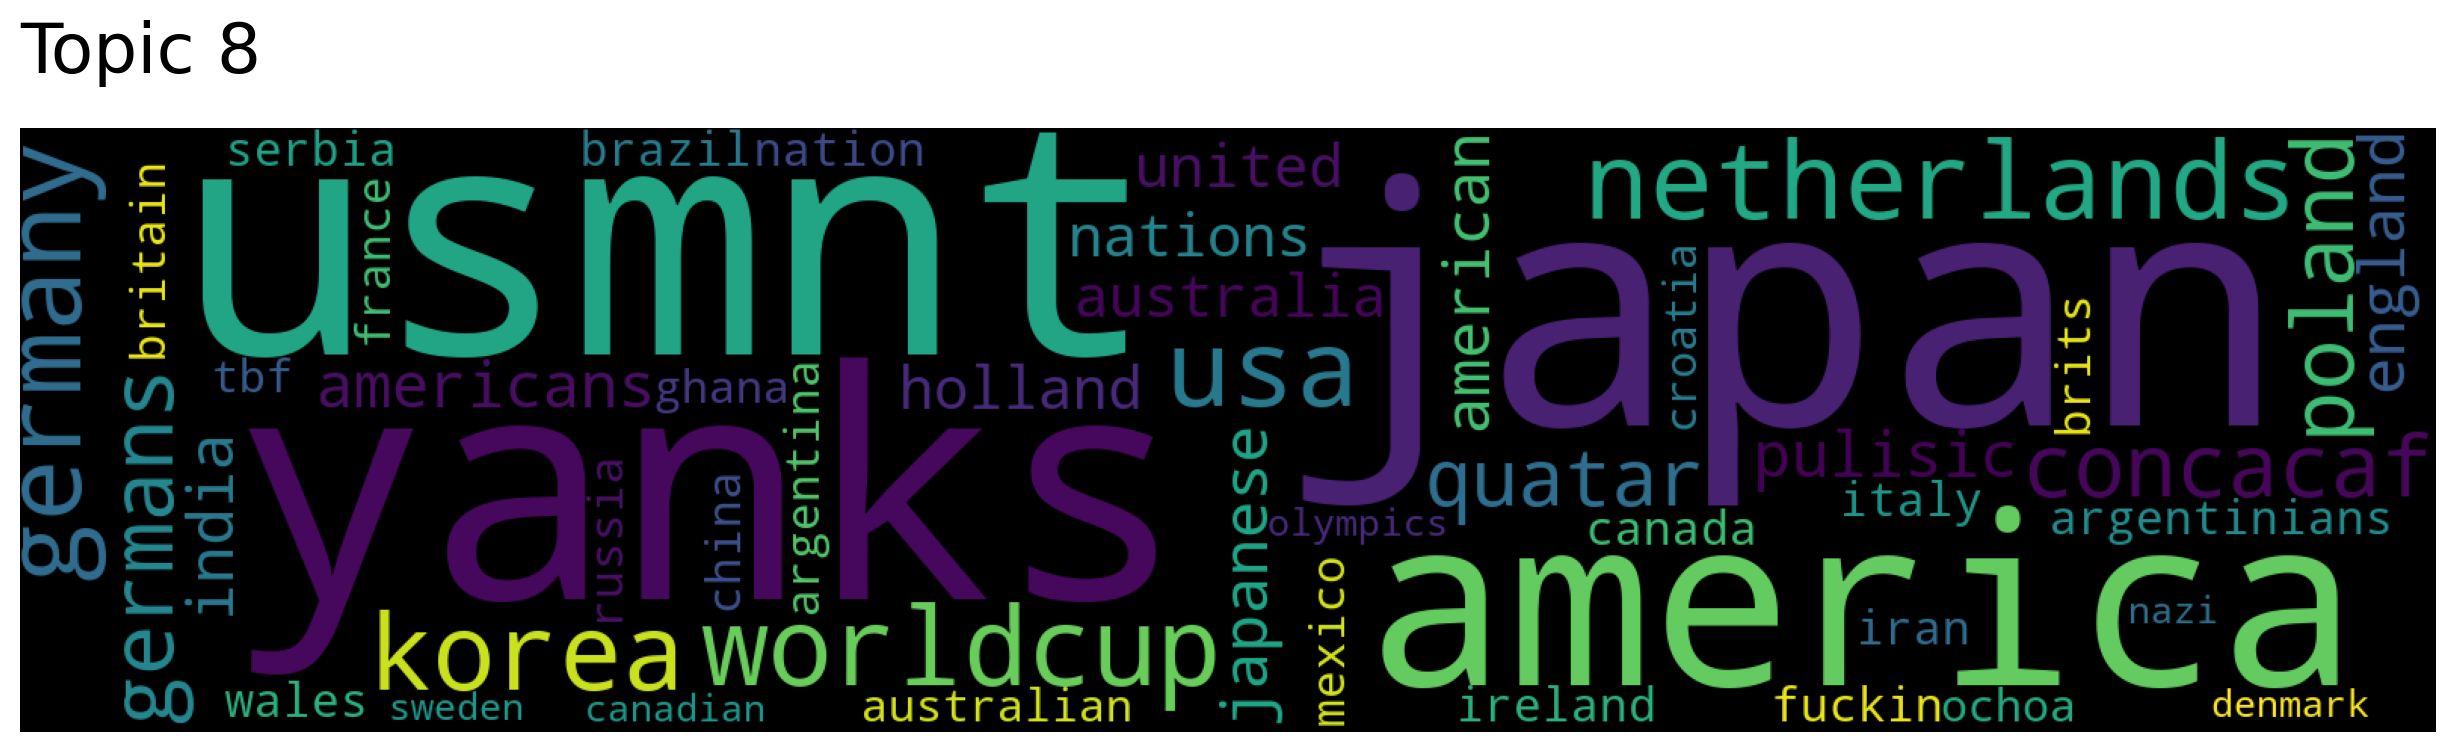

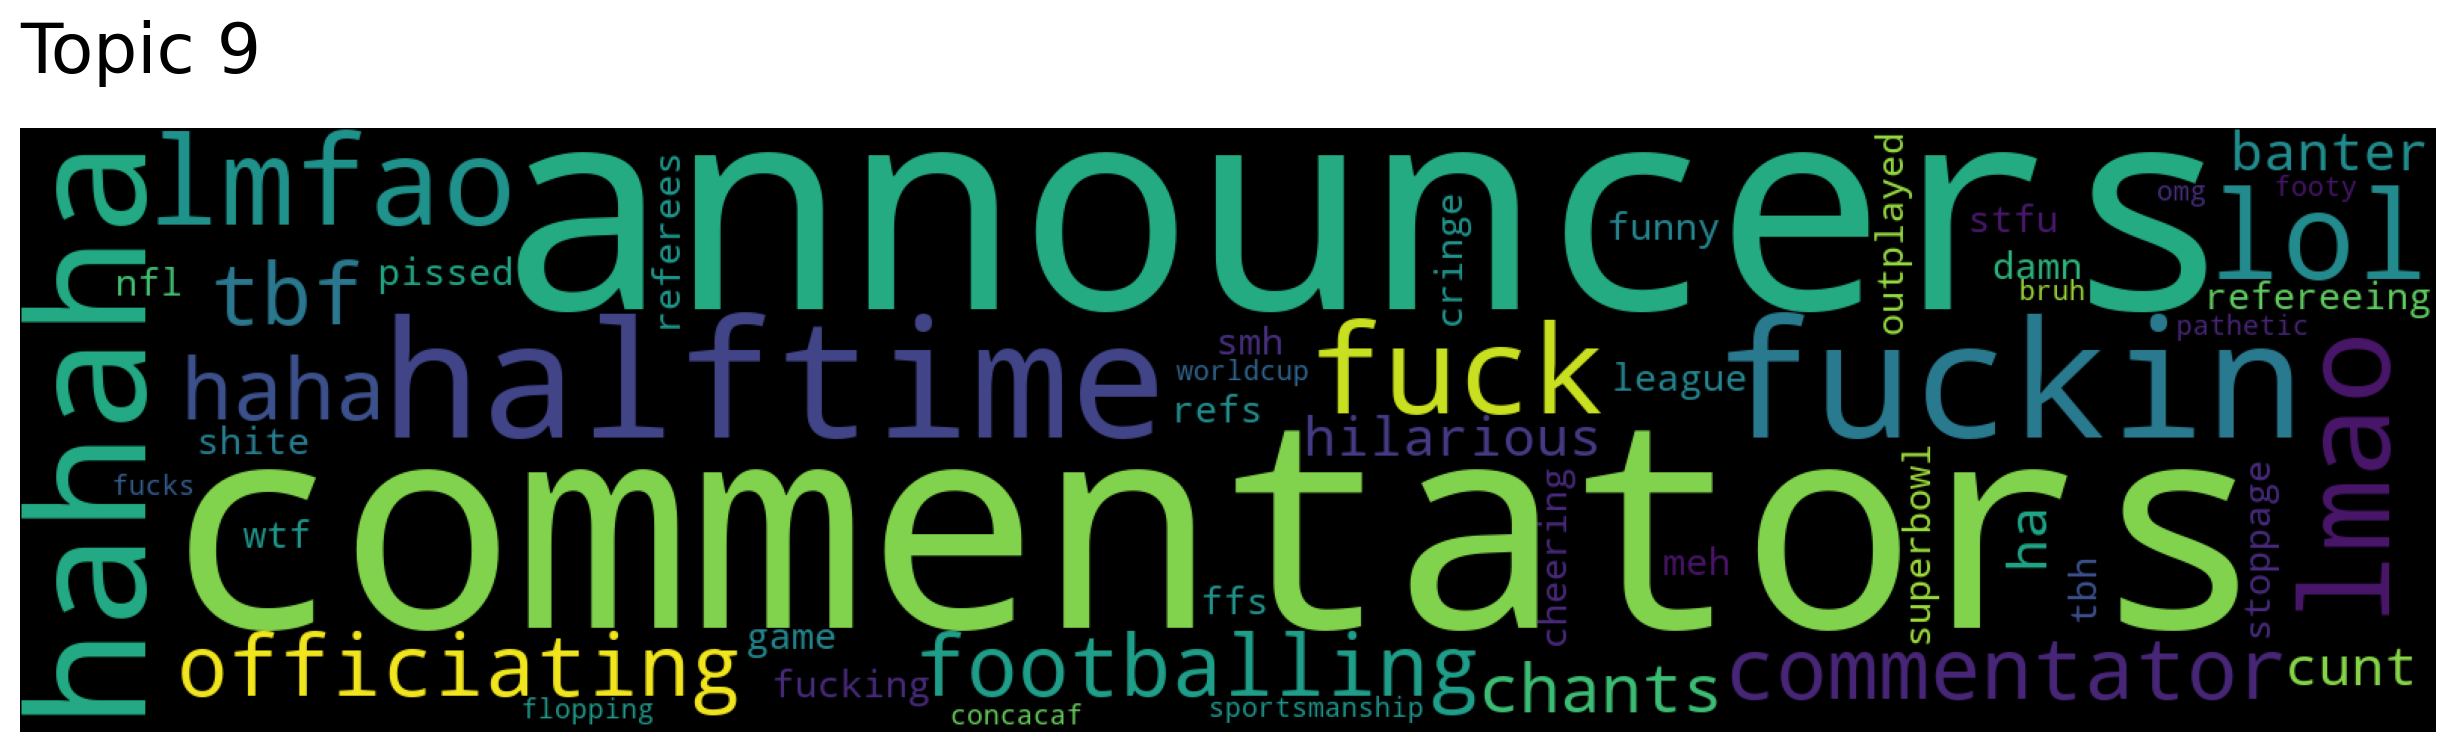

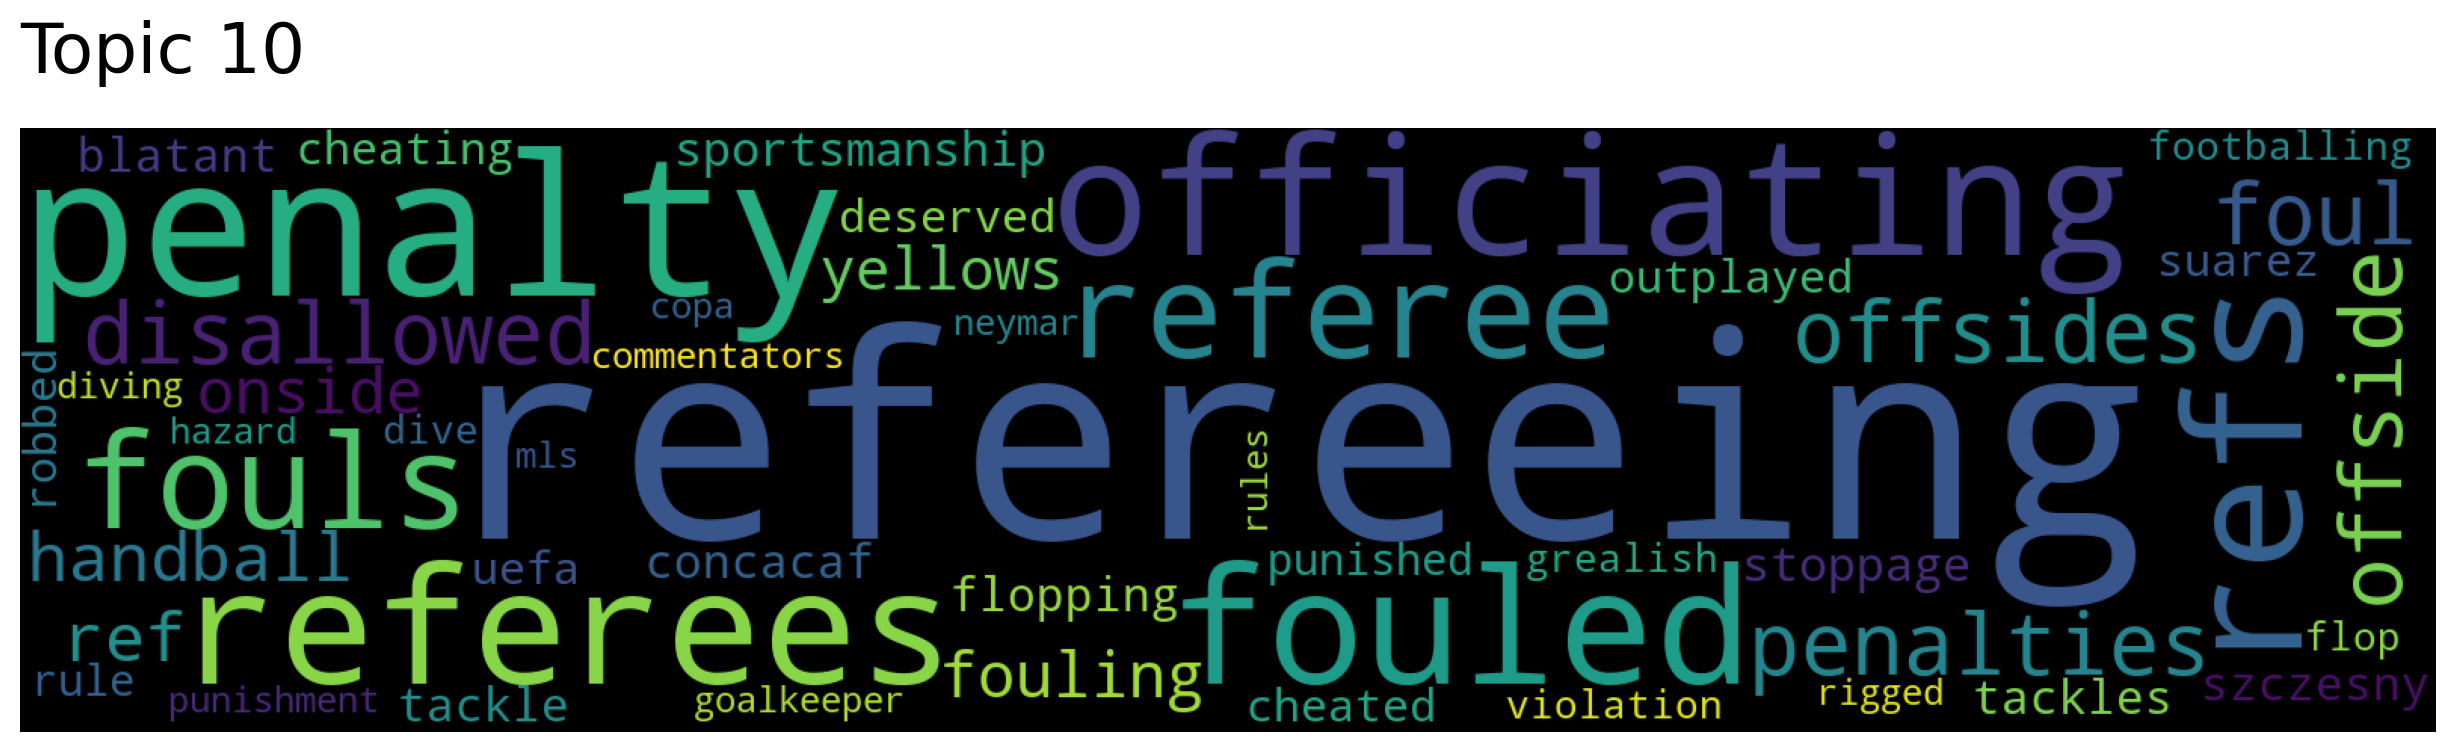

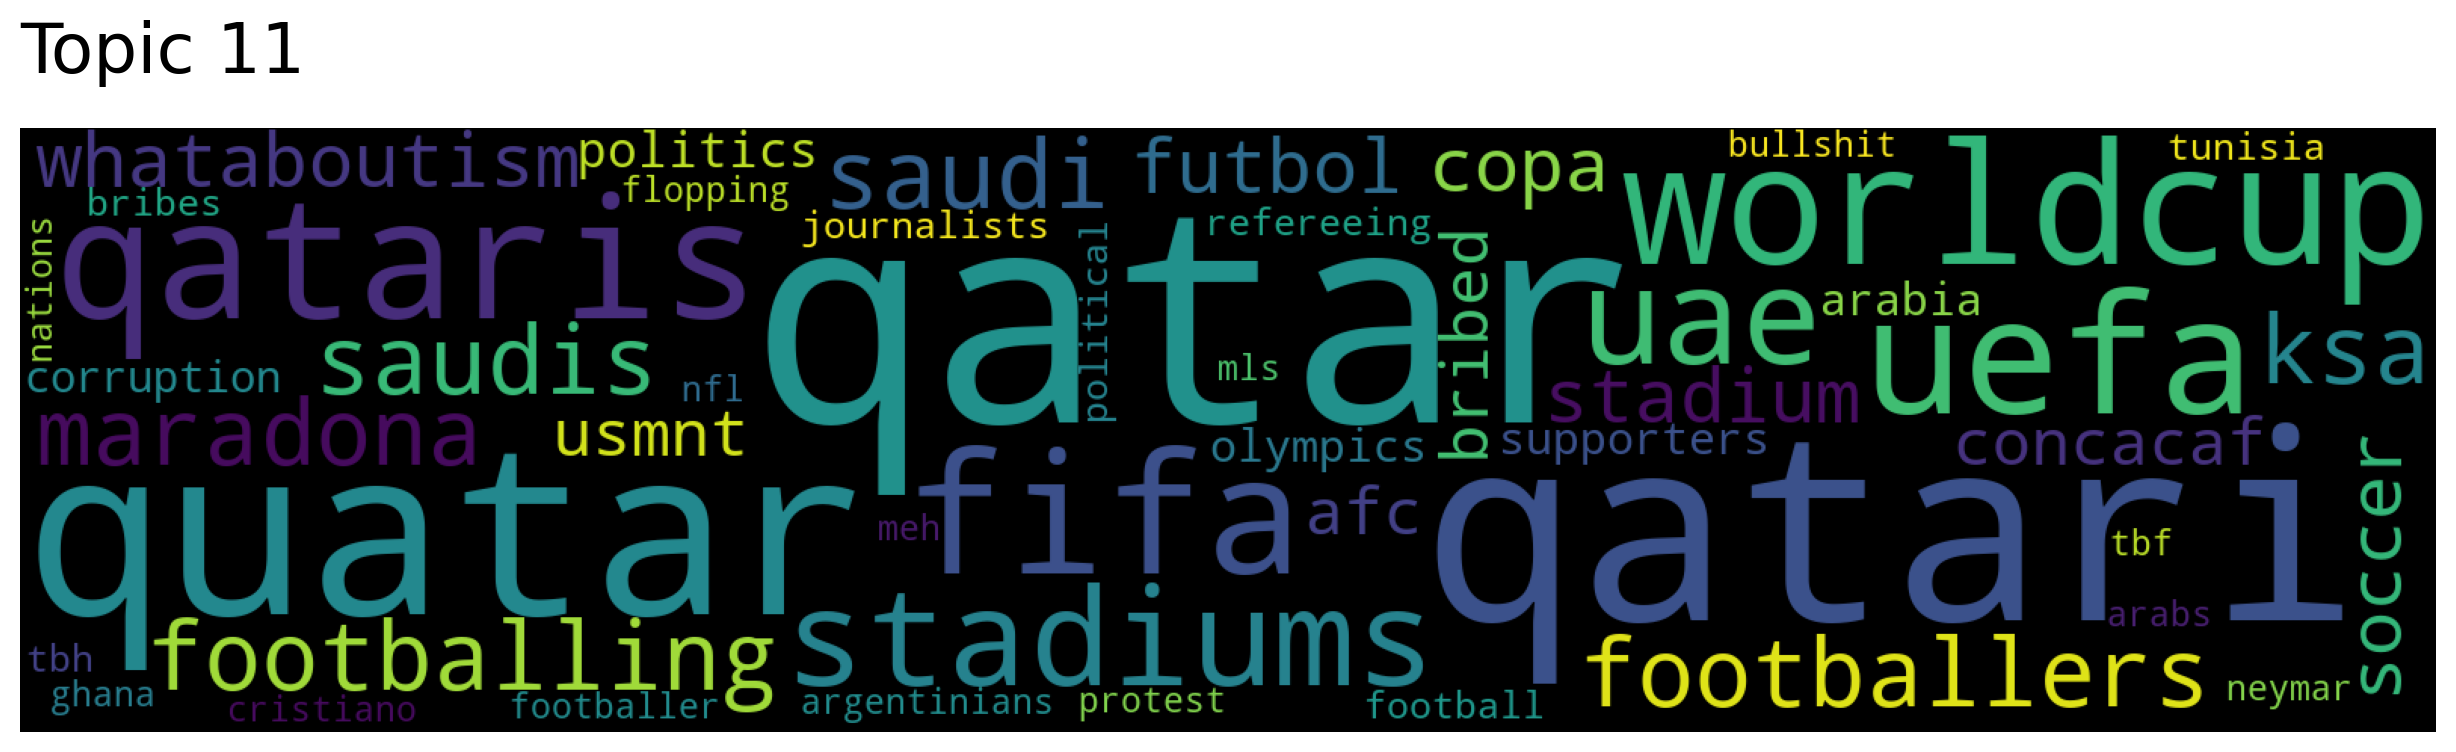

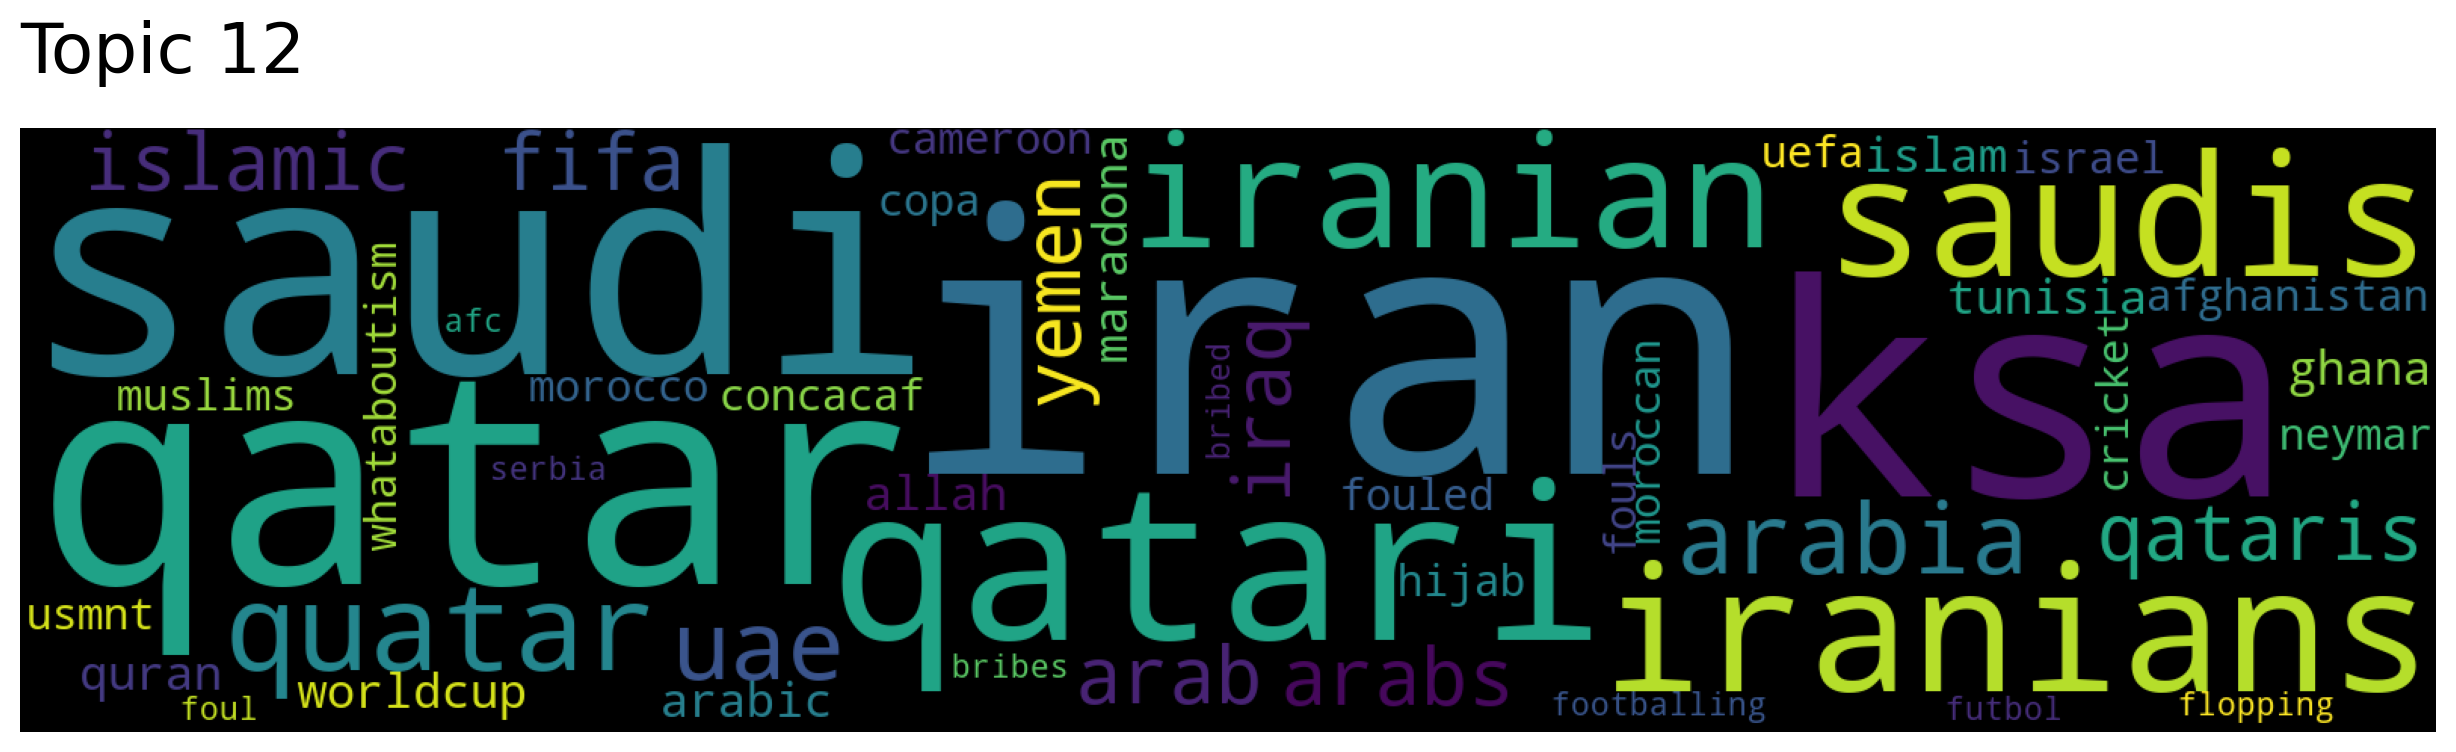

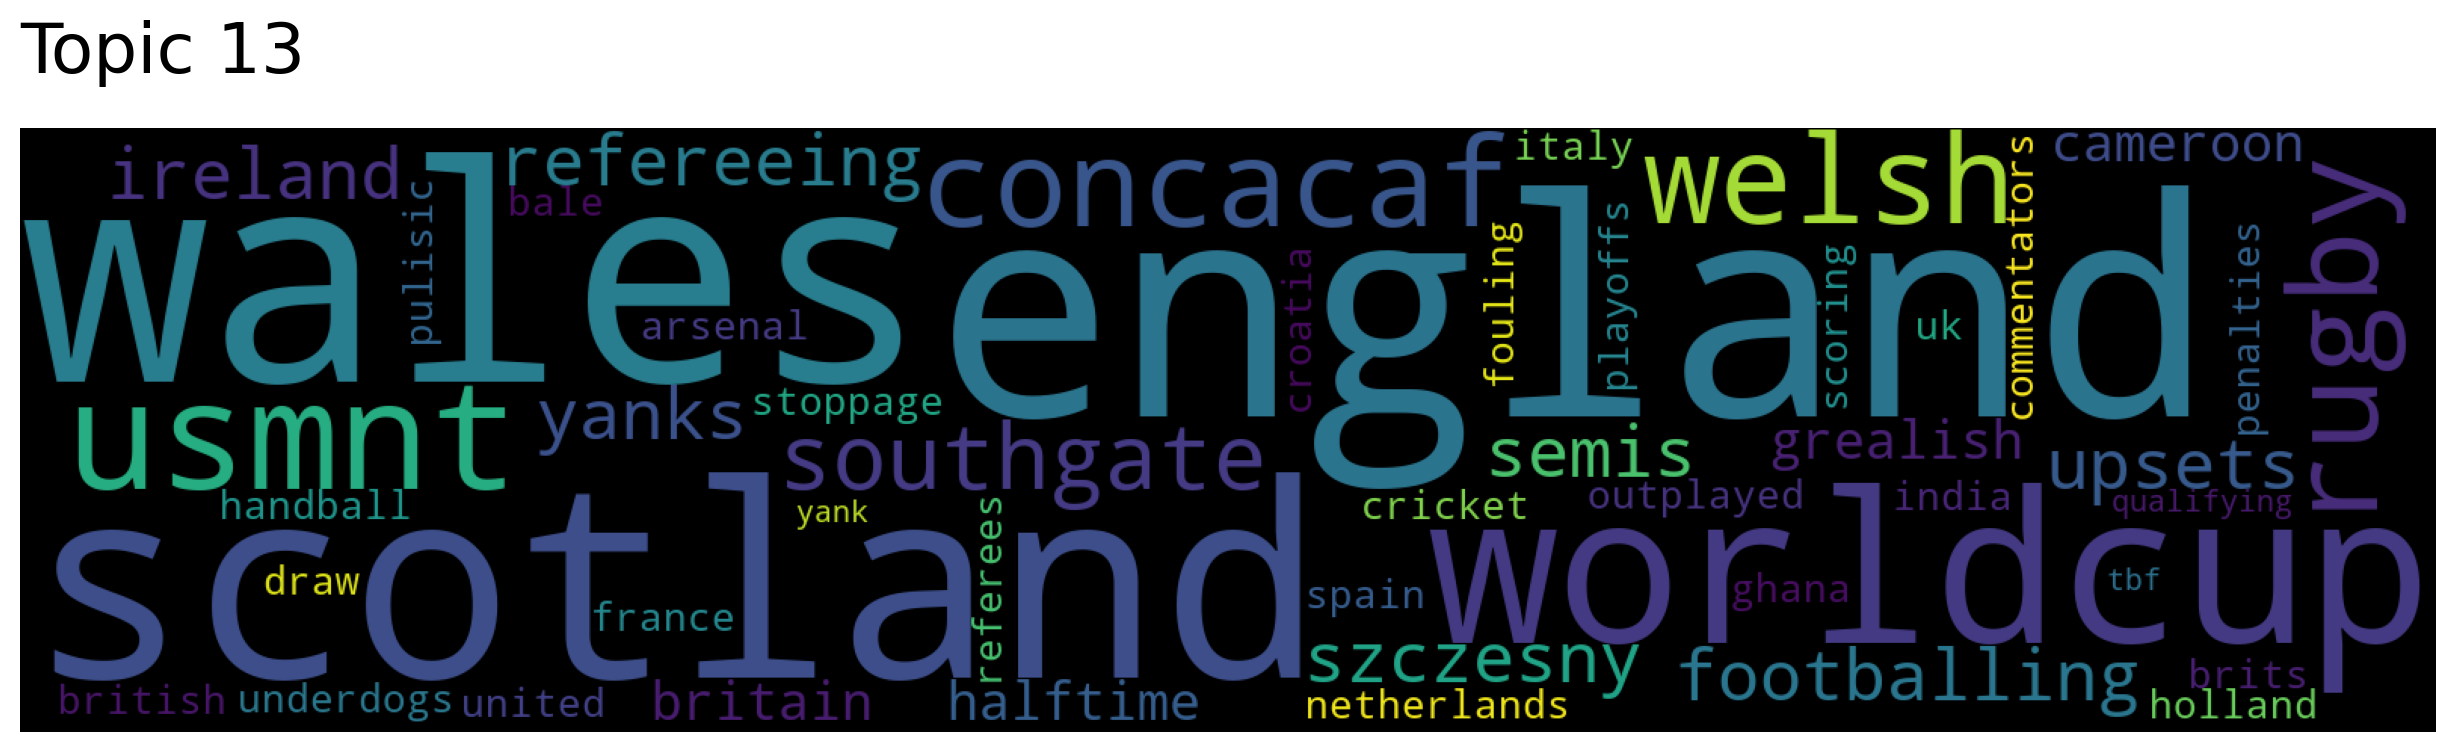

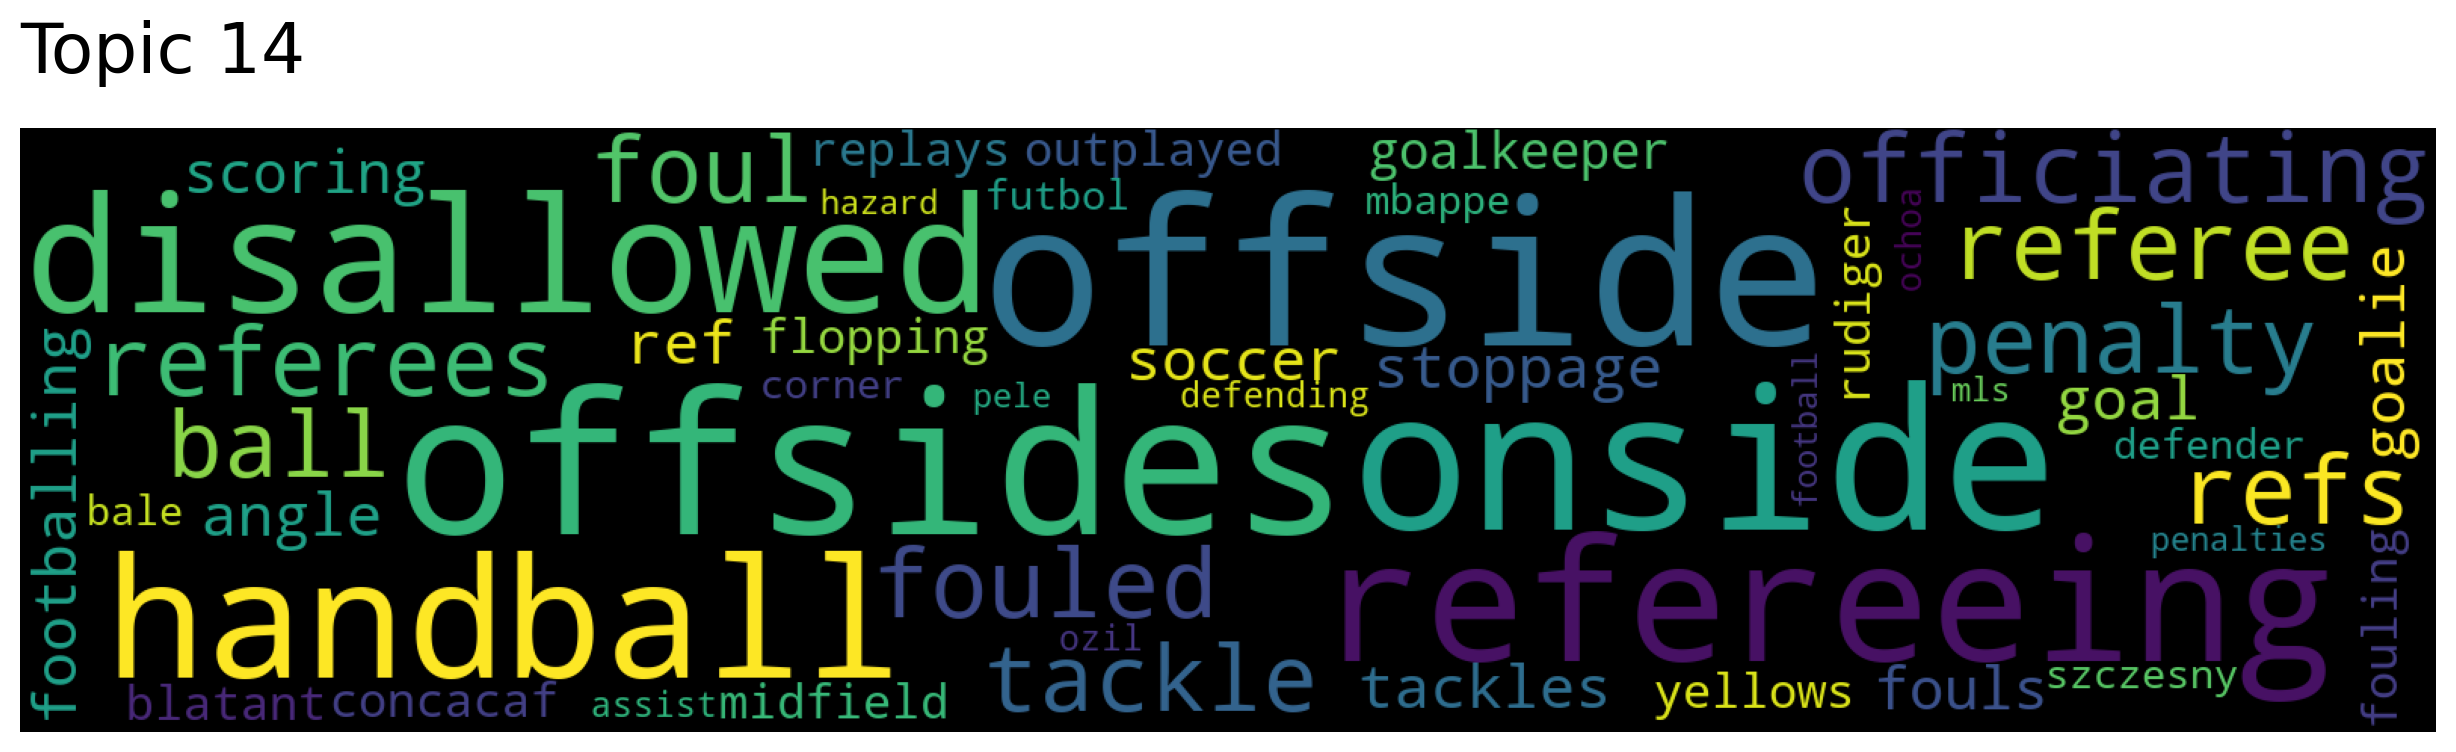

In [62]:
topic_words, word_scores, topic_nums = top2vec_use.get_topics(reduced=True)

for topic in topic_nums:
    top2vec_use.generate_topic_wordcloud(topic, reduced=True)#, background_color="black")

In [ ]:
Want to save: Topic Number, number of documents assigned, Merged Topic Number(?), Top words, example documents, document number

In [31]:
def parse_submissions_exploded(data, latest_time=None):
    doc_list = []
    for submission in data:
        if latest_time is None or submission.get('created_utc', 0) <= latest_time:
            if num_words(submission.get('title', '')) >= 5:
                doc = {'text':submission.get('title', ''), 'created_utc':submission.get('created_utc', 0)}
                doc_list.append(doc)
            reply_list = submission.get('top_level_replies', []) + submission.get('replies', [])
            for reply in reply_list:
                if num_words(reply.get('body', '')) >= 5:
                    doc = {'text':reply.get('body', ''), 'created_utc':reply.get('created_utc', 0)}
                    doc_list.append(doc)
    return doc_list

In [45]:
len(top2vec_use.documents)

79280

In [46]:
top2vec_use.documents[:5]

array(['Of course this is true. Qatar is destroying any possibility that a Muslim country would get an event like this in the future.\n\nIf FIFA wanted it in the Middle East they should have approached Dubai, then we wouldn’t be having these issues.',
       "I kind of agree. In most muslim countries alcohol sales are banned, but special permits are allowed for sellers who are to sell to non muslims after checking ID or something. I'm sure similar rules exist in Qatar. Then why not just use the same thing and let them sell alcohol.? Why ban it?",
       "I'm sure FIFA will be bribed again into doing something like this again in the not too distant future.",
       "As a woman, looking at all the rules Qatar for entering the country made me disregard it completely. There are places in my own country I don't even wanna go because the rules are discriminatory against people like me",
       'The frustration lies in the fact that all this morality is for show. You know these Qataris be get

In [50]:
doc_dict_list[50000:50005]

[{'text': 'I mean, how exactly could it be literal?', 'created_utc': 0},
 {'text': 'correct me im wrong. is this a jojo reference?', 'created_utc': 0},
 {'text': "No, but I've been meaning to check out jojo, maybe its a sign :)",
  'created_utc': 0},
 {'text': 'day 2 of the World Cup', 'created_utc': 1669029484.0},
 {'text': "I got a little confused when i saw the times but then i realized that sharing times don't realy work on a international website...",
  'created_utc': 0}]

array([  9, 143,  35, 111,   9])

topic_num                                               text  \
0          9  Of course this is true. Qatar is destroying an...   
1        143  I kind of agree. In most muslim countries alco...   
2         35  I'm sure FIFA will be bribed again into doing ...   
3        111  As a woman, looking at all the rules Qatar for...   
4          9  The frustration lies in the fact that all this...   

   thread_created_utc  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [60]:
doc_df = pd.DataFrame([{'raw_topic_num':topic_num, 'text':doc_dict['text'], 'thread_created_utc':doc_dict['created_utc']} for topic_num, doc_dict in zip(top2vec_use.doc_top,doc_dict_list)])

topic_mapping_dict_list = []
for reduced_topic_num in range(len(topic_mapping)):
    for raw_topic_num in topic_mapping[reduced_topic_num]:
        topic_mapping_dict_list.append({'reduced_topic_num':reduced_topic_num, 'raw_topic_num':raw_topic_num})
topic_mapping_df = pd.DataFrame(topic_mapping_dict_list)

doc_df = doc_df.merge(topic_mapping_df, on='raw_topic_num', how='left')
doc_df.head()

raw_topic_num                                               text  \
0              9  Of course this is true. Qatar is destroying an...   
1            143  I kind of agree. In most muslim countries alco...   
2             35  I'm sure FIFA will be bribed again into doing ...   
3            111  As a woman, looking at all the rules Qatar for...   
4              9  The frustration lies in the fact that all this...   

   thread_created_utc  reduced_topic_num  
0                 0.0                 11  
1                 0.0                  2  
2                 0.0                 12  
3                 0.0                  2  
4                 0.0                 11

In [61]:
doc_df.groupby('reduced_topic_num').size()

reduced_topic_num
0     9863
1     7674
2     6394
3     4364
4     5356
5     3210
6     4411
7     4874
8     7179
9     6948
10    5293
11    2339
12    6014
13    2700
14    2661
dtype: int64

In [64]:
doc_df[doc_df['reduced_topic_num']==0].sample(50)

raw_topic_num                                               text  \
27829            150  Man that's really complicated, all imma say is...   
72947             90              Get cancer and die you retarded bitch   
63254              5                    That’s literally their plan lol   
23830            217                         The darkness has taken you   
60229              0    Sorry I was too young to pay attention in 2002!   
26373              0  Thats what you think. Your book has a differen...   
14502            184                        If only money had feelings.   
52989             28                       No appreciation for The Who?   
10905            109  Just talking out your ass, no actual facts to ...   
59646              5  Had to double check and make sure this wasn’t ...   
24603              5  Not nearly the same, but people will talk abou...   
12497            122  Lol, others won’t immediately get it, but as a...   
19100              0  Lol at people in the comments. Ultimate ignora...   
18151            128                 That definitely wasn't a sentence.   
54432            103  Thats always an odd argument... We won it, tha...   
1275             127           He'd be the most upvoted user on reddit.   
2527             127  This is a thread where you want to be down vot...   
16629              0  Ignore it then. If it’s making you tired, perh...   
21266            103  This would be heartwarming if it wasn’t so dep...   
46352             63  Knees are behind the line damn it, what’s that...   
76168             85  Why do i have to scroll down for 15 minutes to...   
27880            117  I agree. In fact if I was in their shoes I’d t...   
54171              0             That’s just your piss poor tastes then   
1535              69                       wtf would want to stay here?   
17408             28             Nah I don't judge I just like to argue   
34864             28  Don’t use the N word. And what lol. I love the...   
13684              0  It's gonna blow your little mind when you disc...   
77120            127                came back here to admire my comment   
50474             28            Will, you don't have to trust me buddy.   
54359              0  It didn't go for my head you're just being a m...   
18453             73  "Why do people care so much about hate for mar...   
67507            195  Oh no my first comment isn't ageing well. I ho...   
17087              5                              That was 4 years ago.   
69920             28  Don’t sweat it bud, we all start some where. I...   
7392              28  Yeah your dementia is not really my problem. I...   
40938             28  Dev Hynes (aka Blood Orange). \n\nI will die o...   
16737             73  One existence! Let’s make it as miserable as p...   
38948            150             Perception is not necessarily reality.   
15119             43  Holy shit the comments here are delusional. Ca...   
47798             43  You think that's funny, try watching in Englan...   
53946            194              He is as delusional as your boi Trump   
60731              5                      Ummmmm so that just happened.   
30725             28  edit: just removing so i don't have to deal wi...   
71729            178          Just wondering how much did they pay you?   
15926             78  “I wasnt making fun of one terrible thing. I w...   
12642             99  You're right, it isn't comparable. So why brin...   
11693             43                              Haha nice. Keep it up   
10043             73  Redditors can't stand to see people having fun...   
13390              0  regardless of what reply you were answering to...   
15127            103                       You people are sad hahahaaha   

       thread_created_utc  reduced_topic_num  
27829                 0.0                  0  
72947                 0.0                  0  
63254                 0.0               